In [22]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [23]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = get_class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
# if lang_class_name.endswith("HELM"): #TODO: should be removed after .lang inclusion
#     lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = get_class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = get_class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.00, count_rollouts: 1, reward: 0.23902898211140858, node: CS(=O)(=O)Nc1cc(Br)c(C)c(C)c1
1- time: 0.24, count_rollouts: 5, reward: 0.35673518018692163, node: Fc1cccc(NC(=O)c2ccc(Cl)cc2)c1
2- time: 0.37, count_rollouts: 8, reward: 0.17137216047578618, node: S[C@H](O)[C@H](NC(=O)C(=O)Nc1ccccc1)c1ccccc1
3- time: 0.82, count_rollouts: 17, reward: 0.276869059391963, node: N#Cc1ccccc1COc1cccc(O)c1
4- time: 1.25, count_rollouts: 27, reward: 0.2321890320218868, node: Cc1ccccc1[C@H](O)N1CCC[C@@H](C(=O)NC2CC2)[C@@H]1C
5- time: 1.33, count_rollouts: 29, reward: 0.3721634190069233, node: COc1cccc(C(=O)Nc2ccc(Cl)cc2C)c1
6- time: 1.37, count_rollouts: 30, reward: 0.24018648017089608, node: C[C@H](O)C(=O)Nc1cc(C(=O)N2CCC(C)C2)c(C)cc1Cl
7- time: 1.66, count_rollouts: 36, reward: 0.2522928315351226, node: OC(=O)C[C@@H](C(=O)c1cccc(F)c1F)N(C)CC(C)C
8- time: 2.09, count_rollouts: 46, reward: 0.3458392681465282, node: F[C@@H]1CN(C(=O)c2ccccc2Cl)C[C@@H]1COC(=O)c1ccccc1
9- time:

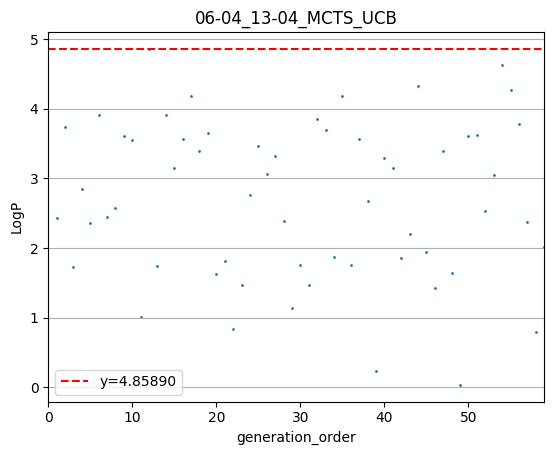

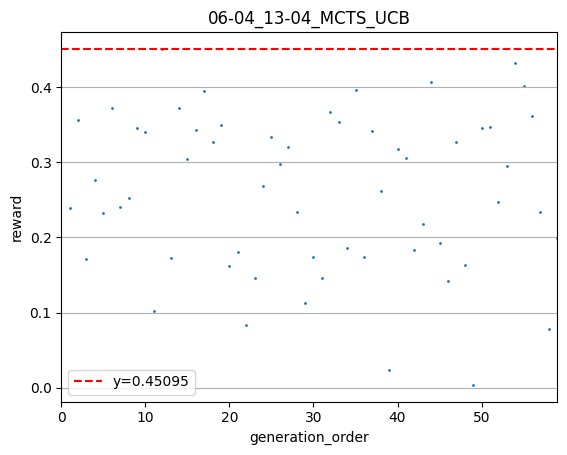

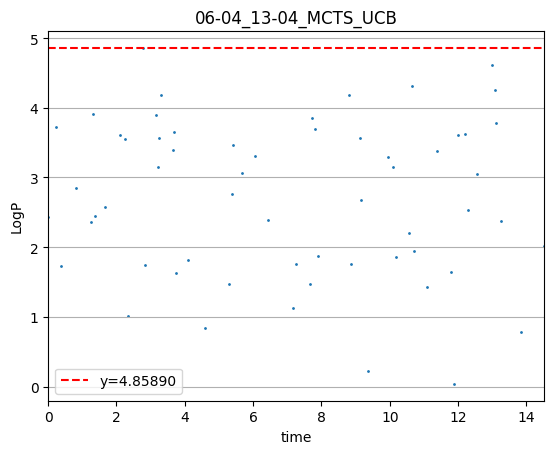

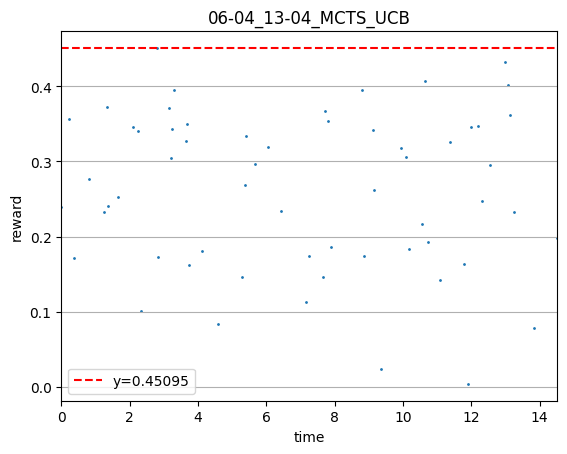

Search is completed.


In [27]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)